In [52]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

In [53]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Напомним значения столбцов:

* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которые приобрёл клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

In [54]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

In [55]:
# избавление от неинформативных признаков
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [56]:
# исследование на пропуски в датасете
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

* BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
* TenureByAge — отношение времени пользования банком к возрасту клиента;
* CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [57]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

In [58]:
# кодировка категориального признака
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [59]:
# разделение набора на матрицу наблюдений и целевой признак
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [60]:
# нормализация матрицы наблюдений
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [61]:
# сбалансированность целевого признака
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Целевой признак несбалансирован.

При разделении нашего набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет оставлять желать лучшего.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать прекрасное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

*** 

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется стратифицированным. 

Как хорошо, что функция train_test_split() из библиотеки sklearn умеет производить такое разбиение! Для этого в функции предусмотрен параметр stratify, который нужно выставить в значение признака. Признак должен иметь одинаковые соотношения в тренировочной и тестовой выборках. У нас этим признаком является целевой признак y.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

# Train shape: (1881, 12)
# Test shape: (628, 12)

Train shape: (1881, 12)
Test shape: (628, 12)


In [63]:
# сбалансированность разделения
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


In [64]:
log_reg=linear_model.LogisticRegression(
    random_state=42,
    solver='sag'
)

In [65]:
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='sag')

In [66]:
y_pred_train=log_reg.predict(X_train)
y_pred_test=log_reg.predict(X_test)

In [67]:
round(metrics.f1_score(y_train, y_pred_train), 2)

0.49

In [68]:
round(metrics.f1_score(y_test, y_pred_test), 2)

0.47

In [69]:
# создание полиномиальных признаков для выборок
poly=preprocessing.PolynomialFeatures(
    degree=3,
    include_bias=False
)

poly.fit(X_train)

PolynomialFeatures(degree=3, include_bias=False)

In [70]:
X_train_poly=poly.transform(X_train)
X_test_poly=poly.transform(X_test)

In [71]:
X_train_poly.shape

(1881, 454)

In [72]:
log_reg.fit(X_train_poly, y_train)

c:\Users\kuzin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=42, solver='sag')

In [73]:
y_pred_train_poly=log_reg.predict(X_train_poly)
y_pred_test_poly=log_reg.predict(X_test_poly)

In [74]:
round(metrics.f1_score(y_train, y_pred_train_poly), 2)

0.66

In [75]:
round(metrics.f1_score(y_test, y_pred_test_poly), 2)

0.64

In [76]:
#Считаем вероятности оттока для каждого из клиентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = pd.Series(log_reg.predict_proba(X_test_poly)[:, 1])
#Создадим список, в которых будем хранить значение метрики 
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Клиентов, для которых вероятность оттока > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    f1_scores.append(metrics.f1_score(y_test, y_pred))

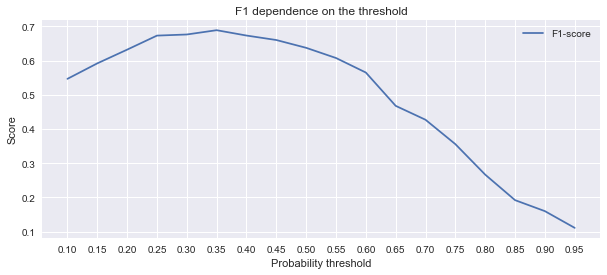

In [77]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [79]:
threshold_opt = 0.35
y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
round(metrics.f1_score(y_test, y_pred_opt), 2)

0.69

In [80]:
from sklearn import tree

In [84]:
dt_clf=tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
dt_clf.fit(X_train, y_train)


dt_y_pred_train=dt_clf.predict(X_train)
dt_y_pred_test=dt_clf.predict(X_test)

In [85]:
round(metrics.f1_score(y_train, dt_y_pred_train), 2)

0.72

In [86]:
round(metrics.f1_score(y_test, dt_y_pred_test), 2)

0.64

## Случайный лес

In [87]:
from sklearn import ensemble

In [88]:
rf_clf=ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10, 
    random_state=42
)

rf_clf.fit(X_train, y_train)

rf_y_pred_train=rf_clf.predict(X_train)
rf_y_pred_test=rf_clf.predict(X_test)

In [89]:
round(metrics.f1_score(y_train, rf_y_pred_train), 2)

0.74

In [90]:
round(metrics.f1_score(y_test, rf_y_pred_test), 2)

0.66

In [94]:
#Считаем вероятности оттока для каждого из клиентов
#Нас интересует только вероятность класса (второй столбец)
rf_y_test_proba_pred = pd.Series(rf_clf.predict_proba(X_test)[:, 1])
#Создадим список, в которых будем хранить значение метрики 
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Клиентов, для которых вероятность оттока > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = rf_y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    f1_scores.append(metrics.f1_score(y_test, y_pred))

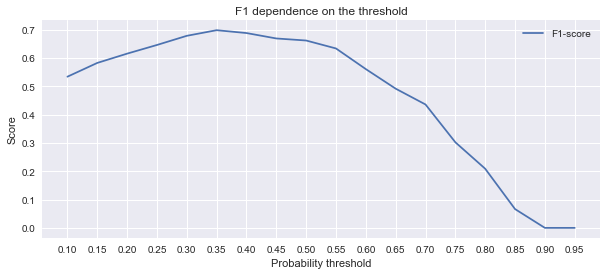

In [95]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [96]:
threshold_opt = 0.35
y_pred_opt = rf_y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
round(metrics.f1_score(y_test, y_pred_opt), 2)

0.7